# Build model that predict house_value in California

In [1]:
import os
import tarfile
import urllib
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.svm import SVR

### Read data

In [ ]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
fetch_housing_data()
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


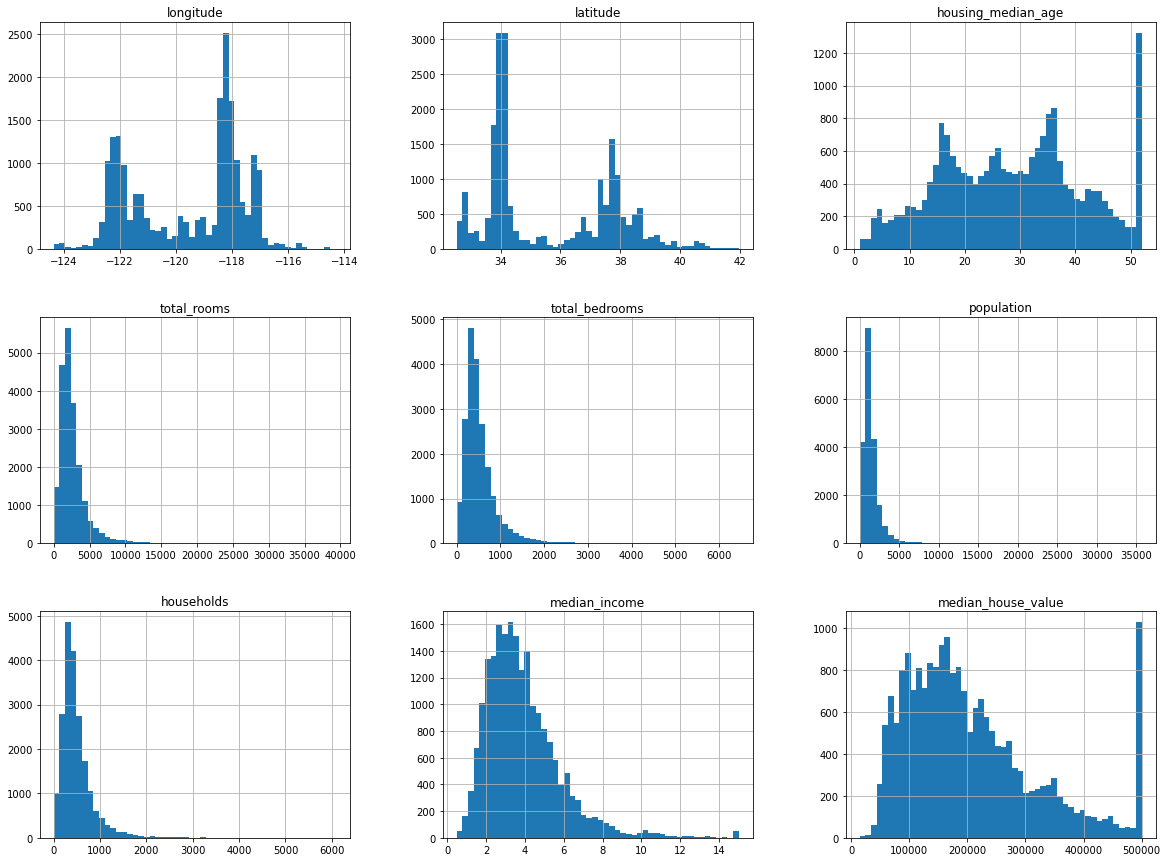

In [8]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [10]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [13]:
###Add categorical value for median_income
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

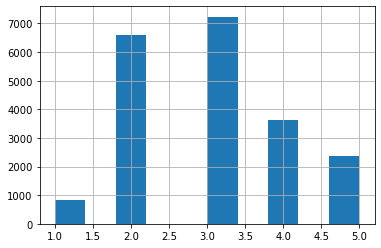

In [15]:
housing["income_cat"].hist()

In [17]:
###train test set based on income_cat
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [18]:
strat_test_set["income_cat"].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [19]:
### now i can cut the income_cat value
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)
    
housing = strat_test_set.copy()


### VISULIZATION DATA

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

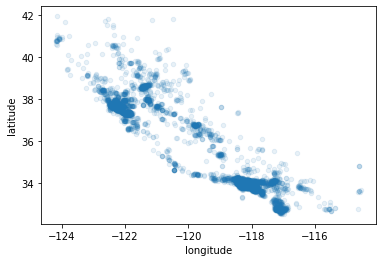

In [22]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1)

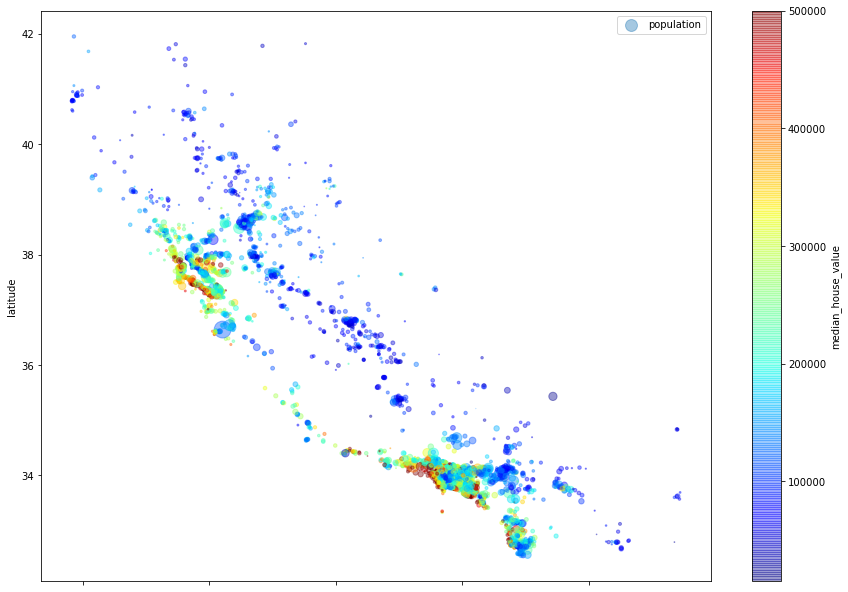

In [25]:
#housing_price visulization
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(15,10.5),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()

In [30]:
#find some correlation 1/a

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)


median_house_value    1.000000
median_income         0.691831
total_rooms           0.131435
housing_median_age    0.071357
households            0.071242
total_bedrooms        0.057568
population           -0.016033
longitude            -0.039987
latitude             -0.150124
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

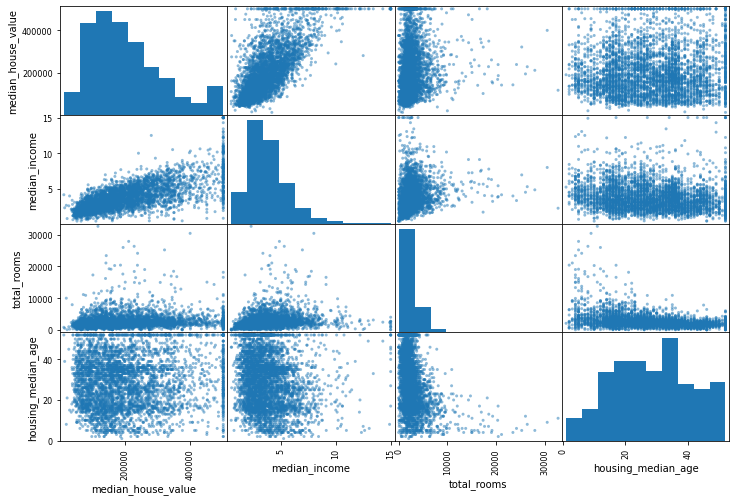

In [31]:
#find some correlation 2/a
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

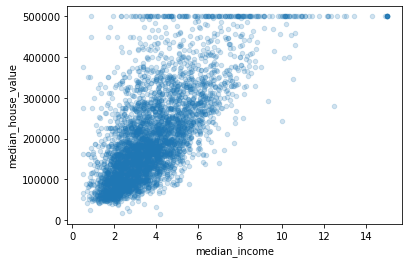

In [35]:
#find some correlation 2/b
housing.plot(kind="scatter", x="median_income", y="median_house_value",alpha=0.2)

In [36]:
#add number of rooms/family, number of bedrooms/rooms, number people in family
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [37]:
#find some correlation 1/b

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending = False)


median_house_value          1.000000
median_income               0.691831
rooms_per_household         0.192575
total_rooms                 0.131435
housing_median_age          0.071357
households                  0.071242
total_bedrooms              0.057568
population                 -0.016033
longitude                  -0.039987
population_per_household   -0.135142
latitude                   -0.150124
bedrooms_per_room          -0.240362
Name: median_house_value, dtype: float64

### Data cleaning

In [39]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()
median = housing["total_bedrooms"].median()  # option 3
housing["total_bedrooms"].fillna(median, inplace=True)

In [42]:
#save median statistics of every variable
imputer = SimpleImputer(strategy="median")
housing_num = housing.drop("ocean_proximity", axis=1) #this value is object type
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [45]:
##substituing all na value with its median
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [49]:
#manipulating object type
ordinal_encoder = OrdinalEncoder()
housing_cat = housing[["ocean_proximity"]]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

### Normalization data

In [54]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [56]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

### ML linear regression model

In [59]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [61]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [64]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
print ("Error on prediction: ", lin_rmse)

Error on prediction:  68628.19819848923


### ML decision tree regression model

In [66]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [67]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print ("Error on prediction: ", tree_rmse)

Error on prediction:  0.0


In [71]:
##There's sure something that goes wrong. Evaluation tree:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print("scores: ",tree_rmse_scores, "Mean: ", tree_rmse_scores.mean(), "Standard deviation: ", tree_rmse_scores.std())

scores:  [70276.48446447 67875.94181954 70707.25677858 69206.39820618
 70263.694169   73614.43984056 70591.51537319 70601.84112847
 76573.16661515 70265.21376771] Mean:  70997.59521628439 Standard deviation:  2299.7563232898538


In [72]:
##There's sure something that goes wrong. Evaluation linear:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print("scores: ",lin_rmse_scores, "Mean: ", lin_rmse_scores.mean(), "Standard deviation: ", lin_rmse_scores.std())

scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067] Mean:  69052.46136345083 Standard deviation:  2731.674001798349


### ML RandomForest regression

In [78]:
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
print ("Error on prediction: ", forest_rmse)

Error on prediction:  18684.269499423488


In [79]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
print("scores: ",forest_rmse_scores, "Mean: ", forest_rmse_scores.mean(), "Standard deviation: ", forest_rmse_scores.std())

scores:  [49495.09854659 47136.05653249 49607.64161706 52398.99643648
 49229.83414008 53715.50242587 48919.4546391  47675.75261437
 52796.43374843 50141.61910267] Mean:  50111.6389803136 Standard deviation:  2074.8375753532027


This is the better model

### Improve model

In [81]:
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [84]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [85]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [86]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63758.43332374591 {'max_features': 2, 'n_estimators': 3}
55318.4799071271 {'max_features': 2, 'n_estimators': 10}
52871.53544112993 {'max_features': 2, 'n_estimators': 30}
60136.06596359763 {'max_features': 4, 'n_estimators': 3}
52147.24477835999 {'max_features': 4, 'n_estimators': 10}
50257.555624093104 {'max_features': 4, 'n_estimators': 30}
58138.50407228864 {'max_features': 6, 'n_estimators': 3}
51845.282291521704 {'max_features': 6, 'n_estimators': 10}
50022.662961207214 {'max_features': 6, 'n_estimators': 30}
58956.79734173122 {'max_features': 8, 'n_estimators': 3}
51748.027712157185 {'max_features': 8, 'n_estimators': 10}
50212.32765434863 {'max_features': 8, 'n_estimators': 30}
62217.83683875648 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54654.27990093937 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60156.47843454898 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52974.85868818559 {'bootstrap': False, 'max_features': 3, 'n_estimators':

### Analyzing best model

In [87]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.76515655e-02, 7.44260795e-02, 4.33658960e-02, 1.88124252e-02,
       1.60167440e-02, 1.82422447e-02, 1.69815340e-02, 3.51534717e-01,
       6.15136677e-02, 1.01491481e-01, 5.74152655e-02, 1.34907833e-02,
       1.36514519e-01, 8.46108585e-05, 5.86311473e-03, 6.59535303e-03])

In [88]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3515347166253509, 'median_income'),
 (0.1365145189152265, 'INLAND'),
 (0.10149148052895184, 'pop_per_hhold'),
 (0.07765156550555713, 'longitude'),
 (0.07442607948350924, 'latitude'),
 (0.06151366766783954, 'rooms_per_hhold'),
 (0.057415265464837745, 'bedrooms_per_room'),
 (0.04336589596327502, 'housing_median_age'),
 (0.01881242518711938, 'total_rooms'),
 (0.018242244674001873, 'population'),
 (0.016981534046159714, 'households'),
 (0.01601674403406252, 'total_bedrooms'),
 (0.013490783284598486, '<1H OCEAN'),
 (0.006595353032472358, 'NEAR OCEAN'),
 (0.005863114728539621, 'NEAR BAY'),
 (8.46108584982291e-05, 'ISLAND')]

### Use model in test data

In [89]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)   # => evaluates to 47,730.2

In [91]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46099.65656343, 50011.78111681])

### Try SVM

In [ ]:
param_grid = [
    {'kernel': ["linear"], 'C': [10., 30., 100., 300., 1000., 3000., 10000.,30000.]},
    {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
  ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)
grid_search_best_estimator_